In [1]:
# Imports
%tensorflow_version 1.x
import numpy as np
from PIL import Image
import requests
from io import BytesIO
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
from scipy.optimize import fmin_l_bfgs_b

Using TensorFlow backend.


In [0]:
# Hyperparams
ITERATIONS = 10
CHANNELS = 3
IMAGE_SIZE = 500
IMAGE_WIDTH = IMAGE_SIZE
IMAGE_HEIGHT = IMAGE_SIZE
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]
CONTENT_WEIGHT = 0.02
STYLE_WEIGHT = 4.5
TOTAL_VARIATION_WEIGHT = 0.995
TOTAL_VARIATION_LOSS_FACTOR = 1.25

In [3]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import os
os.chdir('/content/drive/My Drive/TEST')

In [0]:
import glob
img_array = [filepath for filepath in glob.glob('./Frames/*.jpg')]

In [8]:
img_array

['./Frames/386.jpg',
 './Frames/387.jpg',
 './Frames/388.jpg',
 './Frames/389.jpg',
 './Frames/390.jpg',
 './Frames/391.jpg',
 './Frames/392.jpg',
 './Frames/393.jpg',
 './Frames/394.jpg',
 './Frames/395.jpg',
 './Frames/396.jpg',
 './Frames/397.jpg',
 './Frames/398.jpg',
 './Frames/399.jpg',
 './Frames/400.jpg',
 './Frames/401.jpg',
 './Frames/402.jpg',
 './Frames/403.jpg',
 './Frames/404.jpg',
 './Frames/405.jpg',
 './Frames/406.jpg',
 './Frames/407.jpg',
 './Frames/408.jpg',
 './Frames/409.jpg',
 './Frames/410.jpg',
 './Frames/411.jpg',
 './Frames/412.jpg',
 './Frames/413.jpg',
 './Frames/414.jpg',
 './Frames/415.jpg',
 './Frames/416.jpg',
 './Frames/417.jpg',
 './Frames/418.jpg',
 './Frames/419.jpg',
 './Frames/420.jpg',
 './Frames/421.jpg',
 './Frames/422.jpg',
 './Frames/423.jpg',
 './Frames/424.jpg',
 './Frames/425.jpg',
 './Frames/426.jpg',
 './Frames/427.jpg',
 './Frames/428.jpg',
 './Frames/429.jpg',
 './Frames/430.jpg',
 './Frames/431.jpg',
 './Frames/432.jpg',
 './Frames/43

In [10]:
!pip install python-resize-image

In [0]:
# resize each image
import PIL
from PIL import Image
from resizeimage import resizeimage

In [0]:
if not os.path.exists('./ResizedFrames'):
  os.mkdir('./ResizedFrames')

In [0]:
count = 0
for img_path in img_array:
  img = Image.open(img_path)
  cover = resizeimage.resize_cover(img, [IMAGE_WIDTH,IMAGE_HEIGHT])
  cover.save('./ResizedFrames/'+str(count)+'.jpeg', img.format)
  count += 1 

In [0]:
# resize style image
img = Image.open('./night.jpg')
cover = resizeimage.resize_cover(img, [IMAGE_WIDTH,IMAGE_HEIGHT])
cover.save('./style.jpeg', img.format)

In [0]:
style_image = load_img('./style.jpeg')

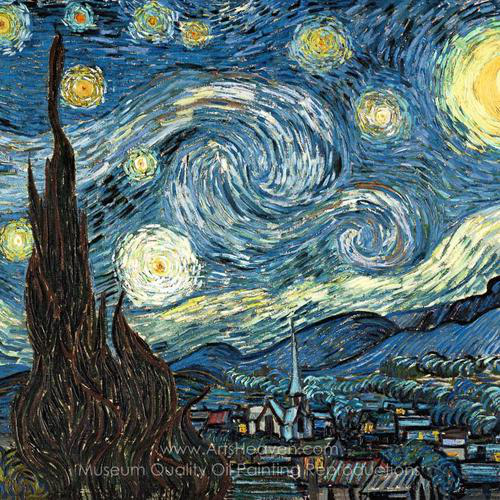

In [31]:
style_image

In [0]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))
    gram = backend.dot(features, backend.transpose(features))
    return gram

In [0]:
import glob
img_array = [filepath for filepath in glob.glob('./ResizedFrames/*.jpeg')]

In [21]:
img_array

['./ResizedFrames/0.jpeg',
 './ResizedFrames/1.jpeg',
 './ResizedFrames/2.jpeg',
 './ResizedFrames/3.jpeg',
 './ResizedFrames/4.jpeg',
 './ResizedFrames/5.jpeg',
 './ResizedFrames/6.jpeg',
 './ResizedFrames/7.jpeg',
 './ResizedFrames/8.jpeg',
 './ResizedFrames/9.jpeg',
 './ResizedFrames/10.jpeg',
 './ResizedFrames/11.jpeg',
 './ResizedFrames/12.jpeg',
 './ResizedFrames/13.jpeg',
 './ResizedFrames/14.jpeg',
 './ResizedFrames/15.jpeg',
 './ResizedFrames/16.jpeg',
 './ResizedFrames/17.jpeg',
 './ResizedFrames/18.jpeg',
 './ResizedFrames/19.jpeg',
 './ResizedFrames/20.jpeg',
 './ResizedFrames/21.jpeg',
 './ResizedFrames/22.jpeg',
 './ResizedFrames/23.jpeg',
 './ResizedFrames/24.jpeg',
 './ResizedFrames/25.jpeg',
 './ResizedFrames/26.jpeg',
 './ResizedFrames/27.jpeg',
 './ResizedFrames/28.jpeg',
 './ResizedFrames/29.jpeg',
 './ResizedFrames/30.jpeg',
 './ResizedFrames/31.jpeg',
 './ResizedFrames/32.jpeg',
 './ResizedFrames/33.jpeg',
 './ResizedFrames/34.jpeg',
 './ResizedFrames/35.jpeg',
 '

In [0]:
def content_loss(content, combination):
    return backend.sum(backend.square(combination - content))

In [0]:
def compute_style_loss(style, combination):
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = IMAGE_HEIGHT * IMAGE_WIDTH
    return backend.sum(backend.square(style - combination)) / (4. * (CHANNELS ** 2) * (size ** 2))

In [0]:
def total_variation_loss(x):
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, TOTAL_VARIATION_LOSS_FACTOR))

In [0]:
def evaluate_loss_and_gradients(x):
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

In [0]:
if not os.path.exists('./StylizedFrames'):
  os.mkdir('./StylizedFrames')

In [0]:
from keras.preprocessing.image import load_img, save_img, img_to_array

In [0]:
style_image = load_img('./style.jpeg')
temp_style_image = style_image

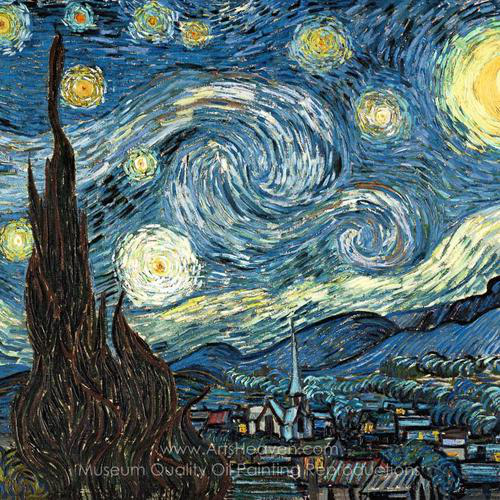

In [37]:
temp_style_image

In [0]:
# APPLY NST
count = 0
for img_path in img_array:
  input_image = load_img(img_path)
  # Data normalization and reshaping from RGB to BGR
  input_image_array = np.asarray(input_image, dtype="float32")
  input_image_array = np.expand_dims(input_image_array, axis=0)
  input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
  input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
  input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
  input_image_array = input_image_array[:, :, :, ::-1]

  style_image_array = np.asarray(temp_style_image, dtype="float32")
  style_image_array = np.expand_dims(style_image_array, axis=0)
  style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
  style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
  style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
  style_image_array = style_image_array[:, :, :, ::-1]
  # Model
  input_image = backend.variable(input_image_array)
  style_image = backend.variable(style_image_array)
  combination_image = backend.placeholder((1, IMAGE_HEIGHT, IMAGE_SIZE, 3))

  input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0)
  model = VGG16(input_tensor=input_tensor, include_top=False)

  layers = dict([(layer.name, layer.output) for layer in model.layers])

  content_layer = "block2_conv2"
  layer_features = layers[content_layer]
  content_image_features = layer_features[0, :, :, :]
  combination_features = layer_features[2, :, :, :]

  loss = backend.variable(0.)
  loss += CONTENT_WEIGHT * content_loss(content_image_features,
                                        combination_features)
  style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"]
  for layer_name in style_layers:
      layer_features = layers[layer_name]
      style_features = layer_features[1, :, :, :]
      combination_features = layer_features[2, :, :, :]
      style_loss = compute_style_loss(style_features, combination_features)
      loss += (STYLE_WEIGHT / len(style_layers)) * style_loss
  loss += TOTAL_VARIATION_WEIGHT * total_variation_loss(combination_image)
  outputs = [loss]
  outputs += backend.gradients(loss, combination_image)
  evaluator = Evaluator()
  x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

  for i in range(ITERATIONS):
      x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
      print("Iteration %d completed with loss %d" % (i, loss))
      
  x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, CHANNELS))
  x = x[:, :, ::-1]
  x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
  x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
  x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
  x = np.clip(x, 0, 255).astype("uint8")
  output_image = Image.fromarray(x)
  output_image.save('./StylizedFrames/'+str(count)+'.png')
  count += 1
  print("xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx")



Iteration 0 completed with loss 69619408896
Iteration 1 completed with loss 49383952384
Iteration 2 completed with loss 42924097536
Iteration 3 completed with loss 40057581568
Iteration 4 completed with loss 38662131712
Iteration 5 completed with loss 37881487360
Iteration 6 completed with loss 37318447104
Iteration 7 completed with loss 36926177280
Iteration 8 completed with loss 36663218176
Iteration 9 completed with loss 36449259520
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx
Iteration 0 completed with loss 66977345536
Iteration 1 completed with loss 49337733120
Iteration 2 completed with loss 42542649344
Iteration 3 completed with loss 40116465664
Iteration 4 completed with loss 38843404288
Iteration 5 completed with loss 37961850880
Iteration 6 completed with loss 37447659520
Iteration 7 completed with loss 37005881344
Iteration 8 completed with loss 36690366464
Iteration 9 completed with loss 36465504256
xxxxxxxxxxxxxxxxxxxxxxxxxxxxxxx